# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/TFM

/content/drive/MyDrive/TFM


In [ ]:
!pip install pydicom --quiet
!pip install -qqq torchmetrics --quiet
!pip install -qqq pytorch-lightning --quiet
!pip install -qqq segmentation-models-pytorch --quiet
!pip install wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pydicom
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, recall_score, precision_score
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import segmentation_models_pytorch as smp

In [ ]:
calc_df = pd.read_csv('data/calc_df.csv')

In [ ]:
# Codificamos la variable pathology para la variable objetivo del modelo de segmentación
map = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
calc_df['labels'] = calc_df['pathology'].replace(map).infer_objects(copy=False)

In [ ]:
def visualizar_mamografia(row, titulo=None):
    """
    Visualiza imagen completa, recorte y máscara ROI desde una fila de dataframe.
    """
    # Lee imágenes dicom
    def cargar_dicom(path):
        if pd.notnull(path) and os.path.exists(path):
            try:
                return pydicom.dcmread(path).pixel_array
            except:
                return None
        return None

    img_full = cargar_dicom(row.get("image file path"))
    img_crop = cargar_dicom(row.get("cropped image file path"))
    img_roi  = cargar_dicom(row.get("ROI mask file path"))

    # Configuramos subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ["Full image", "Cropped image", "ROI mask"]
    images = [img_full, img_crop, img_roi]

    for ax, img, title in zip(axes, images, titles):
        if img is not None:
            ax.imshow(img, cmap='gray')
            ax.set_title(title)
        else:
            ax.set_title(f"{title} (no disponible)")
        ax.axis("off")

    if titulo:
        fig.suptitle(titulo, fontsize=16)

    plt.tight_layout()
    plt.show()
    return img_full, img_crop, img_roi

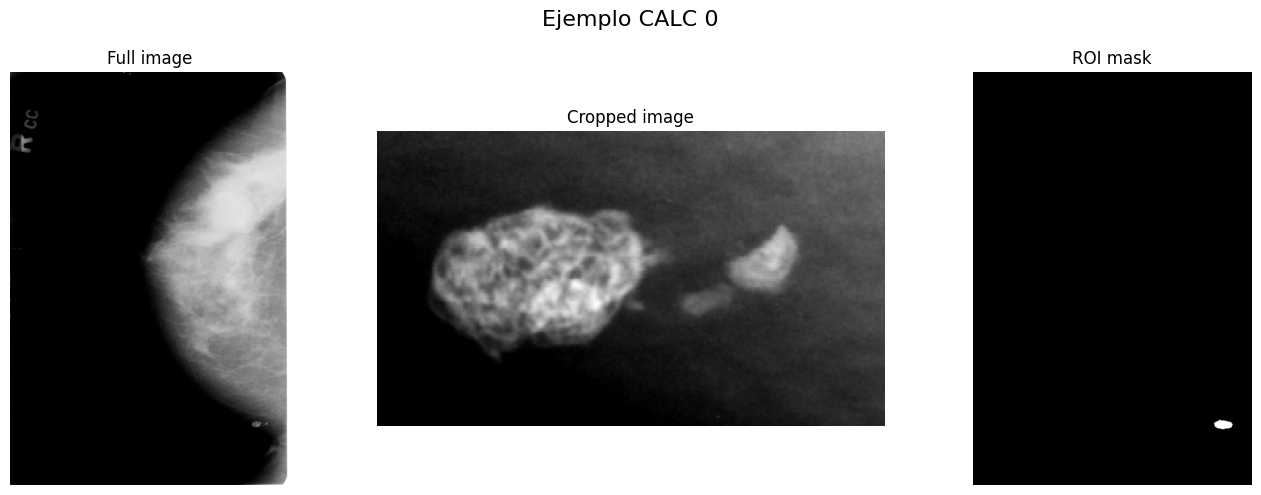

In [ ]:
img_full, img_crop, img_roi = visualizar_mamografia(calc_df.iloc[0], titulo="Ejemplo CALC 0")

# **Preparamos estructuras de Pytorch**

In [ ]:
# Con el comando torchvision.transforms.Compose podemos juntar distintas transformaciones, aunque en este caso solo hay una
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  ])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

# **Dataset**

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df,
                 image_col='image file path',
                 mask_col='ROI mask file path',
                 adjust_data=None,
                 image_transform=None,
                 mask_transform=None,
                 target_size=(224, 224)
                ):
        self.df = df
        self.image_col = image_col
        self.mask_col = mask_col
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data = adjust_data
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Rutas de imagen y máscara
        image_path = self.df.loc[idx, self.image_col]
        mask_path = self.df.loc[idx, self.mask_col]

        # Leemos las imágenes completas en formato dicom
        try:
            ds = pydicom.dcmread(image_path)
            pixel_array = ds.pixel_array.astype(np.float32)

            pixel_array -= pixel_array.min()
            if pixel_array.max() != 0:
                pixel_array /= pixel_array.max()
            pixel_array *= 255.0
            pixel_array = pixel_array.astype(np.uint8)

            image = Image.fromarray(pixel_array).convert("RGB")
            image = image.resize(self.target_size, resample=Image.BILINEAR)
        except Exception as e:
            print(f"Warning: No se pudo cargar la imagen {image_path}. Error: {e}")
            image = Image.fromarray(np.zeros(self.target_size, dtype=np.uint8)).convert("RGB")

        # Leemos las máscaras en formato dicom
        try:
            ds = pydicom.dcmread(mask_path)
            mask_arr = ds.pixel_array.astype(np.uint8)
            mask_arr = (mask_arr > 0).astype(np.uint8)

            mask_pil = Image.fromarray(mask_arr * 255, mode='L')
            mask_pil = mask_pil.resize(self.target_size, resample=Image.NEAREST)
            mask = np.array(mask_pil)
            mask = (mask > 128).astype(np.uint8)  # binarizar tras resize
        except Exception as e:
            print(f"Warning: No se pudo cargar la máscara {mask_path}. Error: {e}")
            mask = np.zeros(self.target_size, dtype=np.uint8)

        # Ajuste
        if self.adjust_data:
            image_np = np.array(image)
            image_np, mask = self.adjust_data(image_np, mask)
            image = Image.fromarray((image_np * 255).astype(np.uint8)).convert("RGB")

        # Transformaciones
        if self.image_transform:
            image = self.image_transform(image).float()
        else:
            image = transforms.ToTensor()(image).float()

        # Convertimos máscara manualmente a tensor (float32) en [0.0, 1.0]
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)  # (1, H, W)

        # Validaciones
        assert mask.ndim == 3, f"Mask shape should be (1,H,W), got {mask.shape}"
        assert mask.max() <= 1.0 and mask.min() >= 0.0, f"Mask values out of bounds: {mask.min()} - {mask.max()}"
        assert mask.sum() > 0, "Warning: Mask is all zeros"

        return image, mask


# Definimos adjust_data para trabajar con arrays de numpy
def adjust_data(img_np, mask_np):
    # Normalizamos valores de los píxels (0, 255)
    img_np = img_np.astype(np.float32) / 255.0
    # Lo convertimos a float32 para el umbral.
    # Si mask_np es binario (0 o 1), la división no cambia nada útil.
    # Si viene de PIL 'L' (0-255), lo normaliza.
    if mask_np.max() > 1:
      mask_np = mask_np.astype(np.float32) / 255.0
      print(np.unique(mask_np))

    # Definimos un umbral para la máscara (asumiendo binaria 0 o 1)
    mask_np[mask_np > 0] = 1.0

    # Devolvemos los arrays numpy procesados
    return (img_np, mask_np)

# Transformaciones PIL a Tensor:  (H, W, C) a (C, H, W) y escale de 0-255 a 0-1
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  ])


# Transformamos las máscaras a Tensor: (H, W, C) a (C, H, W). Si es (H, W), se transforma en (1, H, W)
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

# Now instantiate MyDataset with the updated arguments
# and ensure the target_size is passed to prepare_loaders


# Dividimos el dataset en train, validation y test
def prepare_loaders(df, train_frac=0.65, valid_frac=0.85, bs=32, target_size=(224, 224)):
    train_num = int(df.shape[0] * train_frac)
    valid_num = int(df.shape[0] * valid_frac)

    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num:valid_num].reset_index(drop=True)
    test  = df[valid_num:].reset_index(drop=True)

    # Aplicamos adjust_data al dataset
    train_ds = MyDataset(df=train, image_transform=image_transform, mask_transform=mask_transform, target_size=target_size, adjust_data=adjust_data)
    valid_ds = MyDataset(df=valid, image_transform=image_transform, mask_transform=mask_transform, target_size=target_size, adjust_data=adjust_data)
    test_ds  = MyDataset(df=test,  image_transform=image_transform, mask_transform=mask_transform, target_size=target_size, adjust_data=adjust_data)

    # Creamos DataLoaders
    train_loader = DataLoader(train_ds, batch_size=bs, num_workers=os.cpu_count(), shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=bs, num_workers=os.cpu_count(), shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=4,  num_workers=os.cpu_count(), shuffle=False) # Shuffle test_loader? Usually False.

    print("DataLoaders preparados")
    return train_loader, valid_loader, test_loader

# Llamamos a prepare_loaders con el tamaño deseado
train_loader, valid_loader, test_loader = prepare_loaders(
    df=calc_df,
    train_frac=0.65,
    valid_frac=0.85,
    bs=32,
    target_size=(224, 224)
)

DataLoaders preparados


# **Arquitectura UNet**

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()
        # Inicializamos la clase con el número de canales de entrada (inputs),
        # el número de canales intermedios (middles)
        # y el número de canales de salida (outs)

        # Definimos una capa de convolución (conv1)
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        # Definimos otra capa de convolución (conv2)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        # Definimos la función de activación ReLU
        self.relu = nn.ReLU()
        # Definimos una capa de normalización por batch para estabilizar y acelerar el entrenamiento de la red
        self.bn = nn.BatchNorm2d(outs)
        # Definimos una capa de maxpooling para reducir a la mitad el tamaño espacial de la entrada en cada dimensión
        self.pool = nn.MaxPool2d(2, 2)

    # Este método define la operación de propagación hacia adelante (forward propagation)
    def forward(self, x):
      # Aplicamos conv1 seguido de una activación ReLU,
      # luego aplicamos conv2 seguido de una activación ReLU y normalización por batch (bn).
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))
        # Aplicamos una capa de max pooling (pool)
        # y se devuelve la salida del max pooling junto con la salida intermedia después de conv2
        return self.pool(x), x

In [ ]:
# A continuación se define la arquitectura UNet descrita anteriormente
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        # Definimos 5 bloques encoders
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)

        # Definimos capas de upsampling para aumentar el tamaño de la imagen durante la decodificación.
        # Definimos cuatro bloques de decodificación (de4, de3, de2, de1)

        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)

        # Definimos una capa de convolución final (conv_last) que produce la salida final de la red
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)

    # Definimos la función forward, que especifica cómo se propagan los datos a través de la red.
    # Mostramos también el tamaño de los input/output de cada paso
    def forward(self, x):
        # x: [bs, 3, 256, 256]

        x, e1 = self.en1(x)
        # x: [bs, 64, 128, 128]
        # e1: [bs, 64, 256, 256]

        x, e2 = self.en2(x)
        # x: [bs, 128, 64, 64]
        # e2: [bs, 128, 128, 128]

        x, e3 = self.en3(x)
        # x: [bs, 256, 32, 32]
        # e3: [bs, 256, 64, 64]

        x, e4 = self.en4(x)
        # x: [bs, 512, 16, 16]
        # e4: [bs, 512, 32, 32]

        _, x = self.en5(x)
        # x: [bs, 512, 16, 16]


        x = self.upsample4(x)
        # x: [bs, 512, 32, 32]
        x = torch.cat([x, e4], dim=1)
        # x: [bs, 1024, 32, 32]
        _,  x = self.de4(x)
        # x: [bs, 256, 32, 32]

        x = self.upsample3(x)
        # x: [bs, 256, 64, 64]
        x = torch.cat([x, e3], dim=1)
        # x: [bs, 512, 64, 64]
        _, x = self.de3(x)
        # x: [bs, 128, 64, 64]

        x = self.upsample2(x)
        # x: [bs, 128, 128, 128]
        x = torch.cat([x, e2], dim=1)
        # x: [bs, 256, 128, 128]
        _, x = self.de2(x)
        # x: [bs, 64, 128, 128]

        x = self.upsample1(x)
        # x: [bs, 64, 256, 256]
        x = torch.cat([x, e1], dim=1)
        # x: [bs, 128, 256,256, 256
        _, x = self.de1(x)
        # x: [bs, 64, 256, 256]

        x = self.conv_last(x)
        # x: [bs, 1, 256, 256]

        return x

In [ ]:
class UNETModel(pl.LightningModule):

    def __init__(self,):
        super().__init__()
        # Especificamos el modelo a usar (UNet)
        self.model = UNet()

        # Especificamos la función de pérdida (loss function) que minimizaremos en el modelo
        # ajustando los parámetros del modelo de manera que las predicciones se acerquen
        # lo máximo posible a los valores reales de los datos de entrenamiento.
        pos_weight = torch.tensor([10.0])

        self.loss_fn = lambda pred, target: (
            smp.losses.DiceLoss(mode="binary", from_logits=True)(pred, target) +
            nn.BCEWithLogitsLoss(pos_weight=pos_weight)(pred, target)
        )


        # Inicializamos las listas para acumular outputs por epoch
        self.training_step_outputs = []
        self.validation_step_outputs = []

    # El método forward define cómo se propagan los datos a través del modelo.
    # Toma una imagen como entrada y devuelve la máscara predicha por el modelo.
    def forward(self, image):
        mask = self.model(image)
        return mask

    #  Este método se encarga de realizar una iteración de entrenamiento o validación con un lote de datos dado.
    # Se asegura de que las dimensiones de la imagen y la máscara sean correctas,
    # calcula la pérdida utilizando la función de pérdida definida anteriormente y calcula métricas como precisión, recall, F1 y IoU.
    def shared_step(self, batch, stage):
        image = batch[0]
        assert image.ndim == 4
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]
        assert mask.ndim == 4
        assert mask.max() == 1.0 and mask.min() == 0

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        # Imprime valores únicos de máscaras para verificar que estén bien
        if stage == "train":
            print(f"[{stage}] pred_mask unique values: {pred_mask.unique()}")
            print(f"[{stage}] mask unique values: {mask.unique()}")

        # Imprime suma de tp, fp, fn, tn para verificar que hay datos
        if stage == "train":
            print(f"[{stage}] tp sum: {tp.sum().item()}, fp sum: {fp.sum().item()}, fn sum: {fn.sum().item()}, tn sum: {tn.sum().item()}")

        # Test con sklearn (solo para train para no saturar consola)
        if stage == "train":
            pred_np = pred_mask.cpu().numpy().flatten()
            mask_np = mask.cpu().numpy().flatten()

            print(f"[{stage}] sklearn F1: {f1_score(mask_np, pred_np, zero_division=0):.4f}")
            print(f"[{stage}] sklearn Recall: {recall_score(mask_np, pred_np, zero_division=0):.4f}")
            print(f"[{stage}] sklearn Precision: {precision_score(mask_np, pred_np, zero_division=0):.4f}")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        total_loss = 0
        iter_count = len(outputs)
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()

        # Imprime sumas totales para verificar acumulación correcta
        print(f"[{stage} epoch_end] total tp: {tp.sum().item()}, total fp: {fp.sum().item()}, total fn: {fn.sum().item()}, total tn: {tn.sum().item()}")

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        f1_score_val = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

        metrics = {
            f"{stage}_loss": total_loss / iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score_val,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    # Los métodos training_step, validation_step, test_step son llamados
    # durante el entrenamiento, validación y prueba, respectivamente,
    # y llaman al método shared_step para realizar la iteración.

    # Los métodos training_epoch_end, validation_epoch_end, test_epoch_end
    # son llamados al final de cada época de entrenamiento, validación y prueba, respectivamente,
    # y llaman al método shared_epoch_end para calcular métricas agregadas.
    def training_step(self, batch, batch_idx):
        output = self.shared_step(batch, "train")
        self.training_step_outputs.append(output)
        return output

    def on_train_epoch_end(self):
        if not hasattr(self, "training_step_outputs"):
            self.training_step_outputs = []
        outputs = self.training_step_outputs
        self.shared_epoch_end(outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        output = self.shared_step(batch, "valid")

        if not hasattr(self, "validation_step_outputs"):
            self.validation_step_outputs = []
        self.validation_step_outputs.append(output)

        return output

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        self.shared_epoch_end(outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    # Este método se encarga de configurar el optimizador (Adam) utilizado para entrenar el modelo.
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [ ]:
# Creamos una instancia del modelo UNet y la enviamos al dispositivo especificado (CPU o GPU) para realizar inferencias en los datos de entrada.
model= UNETModel().to(device)

In [ ]:
wandb.login()

wandb_logger = WandbLogger(
    project="mamografia-segmentacion",
    name="test2",
    log_model=True
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elias-pallares (elias-pallares-universitat-pompeu-fabra) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# **Random seed**

In [ ]:
pl.seed_everything(2022)

INFO:lightning_fabric.utilities.seed:Seed set to 2022


2022

# **ModelCheckPoint & EarlyStopping**

In [ ]:
# ModelCheckpoint garantiza que el modelo se guarde automáticamente durante el entrenamiento,
# basado en el puntaje F1 en el conjunto de validación, y solo se guarda el mejor modelo encontrado.
checkpoint_callback = ModelCheckpoint(monitor = "valid_f1_score", mode= 'max',
                                    filename= "model_best",
                                    dirpath ='./',
                                    save_top_k = 1,
                                    save_weights_only=True
                                    )

In [ ]:

early_stop = EarlyStopping(monitor= "valid_f1_score", min_delta=0.00, patience = 20, verbose=True, mode="max")

In [ ]:
# El scheduler permite ajustar dinámicamente la tasa de aprendizaje para mejorar
# la convergencia, evitar el sobreajuste y estabilizar el proceso de entrenamiento.

# Concretamente, StochasticWeightAveraging permite calcular un promedio ponderado de los pesos del modelo durante el entrenamiento,
# lo que puede ayudar a mejorar la generalización y estabilidad del modelo.
# Además, implementa una estrategia de reducción gradual de la tasa de aprendizaje (learning rate)
# al final del entrenamiento para mejorar aún más el rendimiento del modelo.
SWA = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.8, swa_lrs=0.001, annealing_epochs=5, annealing_strategy='cos')

# **Entrenamiento**

In [ ]:
# El objeto Trainer configura el proceso de entrenamiento del modelo,
# especificando el logger, el número de GPUs, el número máximo de epochs
# y los callbacks que se utilizarán durante el entrenamiento.
#Esto permite controlar y supervisar el entrenamiento del modelo de manera eficiente y efectiva.

trainer = pl.Trainer(
    logger = wandb_logger,
    #gpus= -1,
    max_epochs= 10,
    callbacks=[checkpoint_callback, early_stop, SWA])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# El método fit de Trainer se encarga de ejecutar el bucle de entrenamiento completo,
# que incluye múltiples epochs de entrenamiento, evaluación en el conjunto de validación y actualización de los pesos del modelo.
# Durante el entrenamiento, el Trainer registrará automáticamente las métricas, pérdidas (losses)
# y otros datos relevantes utilizando el logger especificado anteriormente (wandb_logger).
trainer.fit(
    model,
    train_dataloaders = train_loader,
    val_dataloaders = valid_loader)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /content/drive/MyDrive/TFM exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 23.4 M | train
---------------------------------------
23.4 M    Trainable params
0         Non-trainable params
23.4 M    Total params
93.501    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[valid epoch_end] total tp: 31187, total fp: 3180077, total fn: 0, total tn: 0


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 10504, fp sum: 1475682, fn sum: 3878, tn sum: 115568
[train] sklearn F1: 0.0140
[train] sklearn Recall: 0.7304
[train] sklearn Precision: 0.0071
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 13872, fp sum: 1529885, fn sum: 801, tn sum: 61074
[train] sklearn F1: 0.0178
[train] sklearn Recall: 0.9454
[train] sklearn Precision: 0.0090
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 30688, fp sum: 853180, fn sum: 2443, tn sum: 719321
[train] sklearn F1: 0.0669
[train] sklearn Recall: 0.9263
[train] sklearn Precision: 0.0347
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 38078, fp sum: 715543, fn sum: 1857, tn sum: 850154
[train] sklearn F1: 0.0960
[train] sklearn Recall: 0.9535
[train] sklear

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved. New best score: 0.026


[valid epoch_end] total tp: 159717, total fp: 11831272, total fn: 0, total tn: 1075
[train epoch_end] total tp: 583324, total fp: 15231951, total fn: 90007, total tn: 23131646
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 19889, fp sum: 242126, fn sum: 12601, tn sum: 1331016
[train] sklearn F1: 0.1351
[train] sklearn Recall: 0.6122
[train] sklearn Precision: 0.0759
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 25091, fp sum: 265834, fn sum: 6426, tn sum: 1308281
[train] sklearn F1: 0.1556
[train] sklearn Recall: 0.7961
[train] sklearn Precision: 0.0862
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 19163, fp sum: 302172, fn sum: 3558, tn sum: 1280739
[train] sklearn F1: 0.1114
[train] sklearn Recall: 0.8434
[train] sklearn Precision: 0.0596
[train] pred_mask unique values: tensor([0., 1.])
[trai

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved by 0.011 >= min_delta = 0.0. New best score: 0.037


[valid epoch_end] total tp: 26419, total fp: 1224388, total fn: 133298, total tn: 10607959
[train epoch_end] total tp: 460737, total fp: 5277902, total fn: 212594, total tn: 33085695
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17091, fp sum: 93304, fn sum: 12697, tn sum: 1482540
[train] sklearn F1: 0.2438
[train] sklearn Recall: 0.5738
[train] sklearn Precision: 0.1548
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 12891, fp sum: 105909, fn sum: 14117, tn sum: 1472715
[train] sklearn F1: 0.1768
[train] sklearn Recall: 0.4773
[train] sklearn Precision: 0.1085
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 9434, fp sum: 113272, fn sum: 8825, tn sum: 1474101
[train] sklearn F1: 0.1338
[train] sklearn Recall: 0.5167
[train] sklearn Precision: 0.0769
[train] pred_mask unique values: tensor([0., 1.])

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved by 0.106 >= min_delta = 0.0. New best score: 0.144


[valid epoch_end] total tp: 83995, total fp: 926118, total fn: 75722, total tn: 10906229
[train epoch_end] total tp: 427191, total fp: 3842424, total fn: 246140, total tn: 34521173
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17859, fp sum: 114853, fn sum: 9362, tn sum: 1463558
[train] sklearn F1: 0.2233
[train] sklearn Recall: 0.6561
[train] sklearn Precision: 0.1346
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 11695, fp sum: 129988, fn sum: 8208, tn sum: 1455741
[train] sklearn F1: 0.1448
[train] sklearn Recall: 0.5876
[train] sklearn Precision: 0.0825
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 5259, fp sum: 126534, fn sum: 7993, tn sum: 1465846
[train] sklearn F1: 0.0725
[train] sklearn Recall: 0.3968
[train] sklearn Precision: 0.0399
[train] pred_mask unique values: tensor([0., 1.])
[t

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved by 0.003 >= min_delta = 0.0. New best score: 0.146


[valid epoch_end] total tp: 102301, total fp: 1138157, total fn: 57416, total tn: 10694190
[train epoch_end] total tp: 406425, total fp: 3354184, total fn: 266906, total tn: 35009413
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 16163, fp sum: 166527, fn sum: 10404, tn sum: 1412538
[train] sklearn F1: 0.1545
[train] sklearn Recall: 0.6084
[train] sklearn Precision: 0.0885
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17282, fp sum: 176914, fn sum: 5983, tn sum: 1405453
[train] sklearn F1: 0.1589
[train] sklearn Recall: 0.7428
[train] sklearn Precision: 0.0890
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 16727, fp sum: 183787, fn sum: 7123, tn sum: 1397995
[train] sklearn F1: 0.1491
[train] sklearn Recall: 0.7013
[train] sklearn Precision: 0.0834
[train] pred_mask unique values: tensor([0., 1.]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved by 0.001 >= min_delta = 0.0. New best score: 0.147


[valid epoch_end] total tp: 106947, total fp: 1187524, total fn: 52770, total tn: 10644823
[train epoch_end] total tp: 441453, total fp: 3825930, total fn: 231878, total tn: 34537667
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 25072, fp sum: 122645, fn sum: 15916, tn sum: 1441999
[train] sklearn F1: 0.2657
[train] sklearn Recall: 0.6117
[train] sklearn Precision: 0.1697
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 16216, fp sum: 142415, fn sum: 10345, tn sum: 1436656
[train] sklearn F1: 0.1751
[train] sklearn Recall: 0.6105
[train] sklearn Precision: 0.1022
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 16466, fp sum: 144846, fn sum: 6889, tn sum: 1437431
[train] sklearn F1: 0.1783
[train] sklearn Recall: 0.7050
[train] sklearn Precision: 0.1021
[train] pred_mask unique values: tensor([0., 1.

Validation: |          | 0/? [00:00<?, ?it/s]

[valid epoch_end] total tp: 123889, total fp: 1825197, total fn: 35828, total tn: 10007150
[train epoch_end] total tp: 433800, total fp: 3448868, total fn: 239531, total tn: 34914729
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 21965, fp sum: 127770, fn sum: 7203, tn sum: 1448694
[train] sklearn F1: 0.2456
[train] sklearn Recall: 0.7531
[train] sklearn Precision: 0.1467
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 5575, fp sum: 151902, fn sum: 2853, tn sum: 1445302
[train] sklearn F1: 0.0672
[train] sklearn Recall: 0.6615
[train] sklearn Precision: 0.0354
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 10235, fp sum: 136812, fn sum: 6129, tn sum: 1452456
[train] sklearn F1: 0.1253
[train] sklearn Recall: 0.6255
[train] sklearn Precision: 0.0696
[train] pred_mask unique values: tensor([0., 1.])


Validation: |          | 0/? [00:00<?, ?it/s]

[valid epoch_end] total tp: 108256, total fp: 1296011, total fn: 51461, total tn: 10536336
[train epoch_end] total tp: 446899, total fp: 3708764, total fn: 226432, total tn: 34654833
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 21337, fp sum: 143845, fn sum: 8068, tn sum: 1432382
[train] sklearn F1: 0.2193
[train] sklearn Recall: 0.7256
[train] sklearn Precision: 0.1292
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17120, fp sum: 128185, fn sum: 10664, tn sum: 1449663
[train] sklearn F1: 0.1978
[train] sklearn Recall: 0.6162
[train] sklearn Precision: 0.1178
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 6556, fp sum: 114938, fn sum: 7324, tn sum: 1476814
[train] sklearn F1: 0.0969
[train] sklearn Recall: 0.4723
[train] sklearn Precision: 0.0540
[train] pred_mask unique values: tensor([0., 1.])

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_f1_score improved by 0.008 >= min_delta = 0.0. New best score: 0.155


[valid epoch_end] total tp: 92229, total fp: 934802, total fn: 67488, total tn: 10897545
[train epoch_end] total tp: 425514, total fp: 3320809, total fn: 247817, total tn: 35042788
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 34382, fp sum: 135352, fn sum: 10566, tn sum: 1425332
[train] sklearn F1: 0.3203
[train] sklearn Recall: 0.7649
[train] sklearn Precision: 0.2026
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 12144, fp sum: 167911, fn sum: 1948, tn sum: 1423629
[train] sklearn F1: 0.1251
[train] sklearn Recall: 0.8618
[train] sklearn Precision: 0.0674
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 9419, fp sum: 183353, fn sum: 3902, tn sum: 1408958
[train] sklearn F1: 0.0914
[train] sklearn Recall: 0.7071
[train] sklearn Precision: 0.0489
[train] pred_mask unique values: tensor([0., 1.])
[

Validation: |          | 0/? [00:00<?, ?it/s]

[valid epoch_end] total tp: 119420, total fp: 1832866, total fn: 40297, total tn: 9999481
[train epoch_end] total tp: 444850, total fp: 3878483, total fn: 228481, total tn: 34485114
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 20248, fp sum: 136874, fn sum: 14905, tn sum: 1433605
[train] sklearn F1: 0.2106
[train] sklearn Recall: 0.5760
[train] sklearn Precision: 0.1289
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 3367, fp sum: 109022, fn sum: 3033, tn sum: 1490210
[train] sklearn F1: 0.0567
[train] sklearn Recall: 0.5261
[train] sklearn Precision: 0.0300
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 6175, fp sum: 78386, fn sum: 11107, tn sum: 1509964
[train] sklearn F1: 0.1213
[train] sklearn Recall: 0.3573
[train] sklearn Precision: 0.0730
[train] pred_mask unique values: tensor([0., 1.])
[

Validation: |          | 0/? [00:00<?, ?it/s]

[valid epoch_end] total tp: 134598, total fp: 2311360, total fn: 25119, total tn: 9520987
[train epoch_end] total tp: 395629, total fp: 3557910, total fn: 277702, total tn: 34805687
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17794, fp sum: 145212, fn sum: 6661, tn sum: 1435965
[train] sklearn F1: 0.1898
[train] sklearn Recall: 0.7276
[train] sklearn Precision: 0.1092
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 17096, fp sum: 135296, fn sum: 6033, tn sum: 1447207
[train] sklearn F1: 0.1948
[train] sklearn Recall: 0.7392
[train] sklearn Precision: 0.1122
[train] pred_mask unique values: tensor([0., 1.])
[train] mask unique values: tensor([0., 1.])
[train] tp sum: 27821, fp sum: 138947, fn sum: 16746, tn sum: 1422118
[train] sklearn F1: 0.2633
[train] sklearn Recall: 0.6243
[train] sklearn Precision: 0.1668
